In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as mgrid
import matplotlib.colors as mpc
import numpy as np
import h5py

import warnings

from activ.readfile import TrackTBIFile
from activ.nmf.viz import bases_heatmap, bases_factor_order, get_percent_top, plot_bases, plot_weights,\
                          nmfplot, plot_umap_nmf_piechart, plot_umap_nmf_max, plot_umap_nmf_weight, cumulative_plot,\
                          plot_umap_nmf_weight_kde

import scipy.spatial.distance as spd
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

import itertools as it
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable
import latex
from umap import UMAP

/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.coordinate_descent module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: 

In [2]:
tbifile_path = 'tracktbi.reg_nmf.h5'
tbifile = TrackTBIFile(tbifile_path)
bm_weights, bm_bases = tbifile.nmf.bm, tbifile.nmf.bm_bases
oc_weights, oc_bases = tbifile.nmf.oc, tbifile.nmf.oc_bases

In [3]:
bm_labels = get_percent_top(tbifile.biomarker_features, bm_bases, perc=0.9)
oc_labels = get_percent_top(tbifile.outcome_features, oc_bases, perc=0.9)

In [4]:
bm_colors = sns.color_palette('Accent', 8)
bm_colors = np.array([bm_colors[i] for i in (6,5,4,2,0)])

oc_colors = sns.color_palette('Set2', 8)
oc_colors = np.array([oc_colors[i] for i in (0, 1, 6, 7, 4, 5, 2, 3)])

In [5]:
bm_emb = UMAP(n_components=2, min_dist=1.0, random_state=20001).fit_transform(tbifile.biomarkers)

binary = list()
continuous = list()
for i in range(tbifile.outcomes.shape[1]):
    # print(tbifile.outcome_features[i], np.unique(tbifile.outcomes[:, i]))
    uniq = np.unique(tbifile.outcomes[:, i])
    if len(uniq) == 2:
        binary.append(i)
    else:
        continuous.append(i)

bindist = spd.pdist(tbifile.outcomes[:, binary], metric='jaccard')
contdist = spd.pdist(tbifile.outcomes[:, continuous], metric='euclidean')

finaldist = (len(binary)*bindist/bindist.max() + len(continuous)*contdist/contdist.max())/tbifile.outcomes.shape[1]

oc_emb = UMAP(n_components=2, min_dist=0.5, random_state=20004, metric='precomputed').fit_transform(spd.squareform(finaldist))

In [6]:
with h5py.File(tbifile_path, 'a') as f:
    TrackTBIFile.write_viz(f, bm_emb=bm_emb, oc_emb=oc_emb, bm_colors=bm_colors, oc_colors=oc_colors, overwrite=True)

In [7]:
from io import StringIO

def write_groups_pdf(labels, label_names, path):
    ltx = StringIO()
    pr = lambda x: print(x, file=ltx)


    pr("\documentclass{article}")
    pr("\\usepackage{geometry}")
    pr("\\geometry{a4paper, portrait, left=.75in, right=.75in, top=2in, bottom=2in}")

    pr("\\usepackage{multicol}")
    pr("\\begin{document}")

    for i in range(len(labels)):
        pr('\section{%s}' % label_names[i])
        pr("\\begin{multicols}{2}")
        pr("\\begin{enumerate}")
        for lbl in labels[i]:
            pr("\item %s" % lbl)
        pr("\\end{enumerate}")
        pr("\\end{multicols}")
        pr("\\newpage")

    pr("\end{document}")
    s = ltx.getvalue().replace('_', '\\textunderscore ')
    latex.build_pdf(s).save_to(path)

In [8]:
oc_bases_labels = np.array([
    'Insomnia',
    'Dysphoria and\ndepression', # Depression
    'LT cognitive\nimpairment', # long-term cognitive deficits
    'ST cognitive\nimpairment', # short-term cognitive deficits
    'Dizziness and\nheadache',
    'Verbal working\nmemory',    # verbal learning
    'Good outcome',     # Recovered
    'Positive PTSD' # PTSD
])
write_groups_pdf(oc_labels, oc_bases_labels, 'outcome_nmf_classes-2.pdf')

In [9]:
bm_bases_labels = np.array([
    'SES-related',    # mild/discharged
    'PE age-related',             # pre-existing health conditions and age
    'PE substance-related',    # pre-existing psych
    'Severe TBI',        # severe injury
#    'GCS and general\nseverity measures'                     # general severity measure
    'Mild TBI'
])
#nmfplot(bm_weights, bm_bases, axes=axes, bases_labels=bm_bases_labels)
write_groups_pdf(bm_labels, bm_bases_labels, 'biomarker_nmf_classes.pdf')

In [10]:
TrackTBIFile.write_feat_types("tracktbi.reg_nmf.h5", 
                              {'nmf': bm_bases_labels[np.argmax(bm_bases, axis=0)]}, 
                              {'nmf': oc_bases_labels[np.argmax(oc_bases, axis=0)]}, overwrite=True)

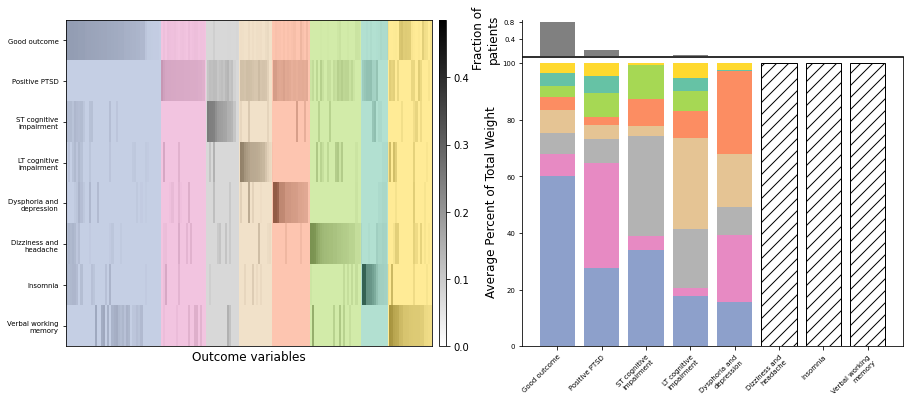

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax_hm = axes[0]
ax_bp = axes[1]
ax_bp2 = make_axes_locatable(ax_bp).append_axes("top", 0.5, pad=0.02, sharex=ax_bp)
axes = [ax_hm, ax_bp2, ax_bp]
factor_order = nmfplot(oc_weights, oc_bases, axes=axes, bases_order=False, bases_labels=oc_bases_labels, 
                       fontsize='large', heatmap_xlabel="Outcome variables", labelsize='x-small', palette=oc_colors)

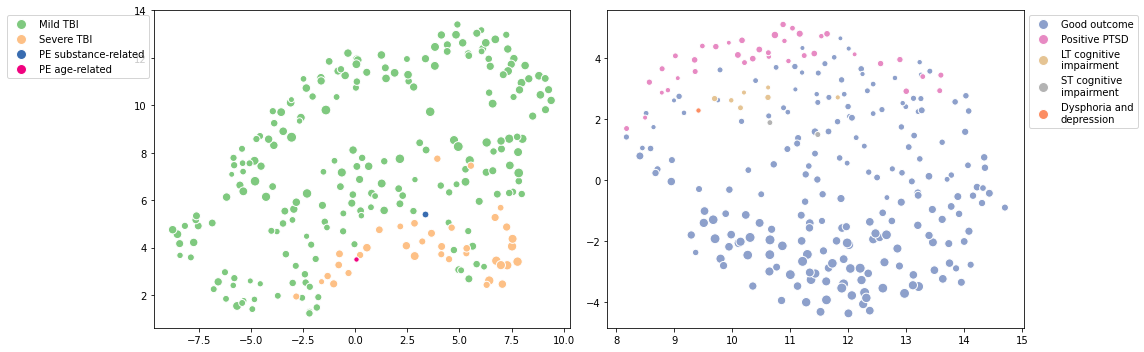

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plot_umap_nmf_max(bm_emb, bm_weights, bm_bases_labels, min_dist=1.0, palette=bm_colors)
plt.subplot(1,2,2)
plot_umap_nmf_max(oc_emb, oc_weights, oc_bases_labels, right=True, palette=oc_colors)
plt.tight_layout()
plt.savefig("nmf_labelled_umap.png", dpi=200)

# multi-panel figure 
- a, b, c - bm barplot, bm heatmap, bm umap-pie-chart
- d, e, f - oc barplot, oc heatmap, oc umap-pie-chart

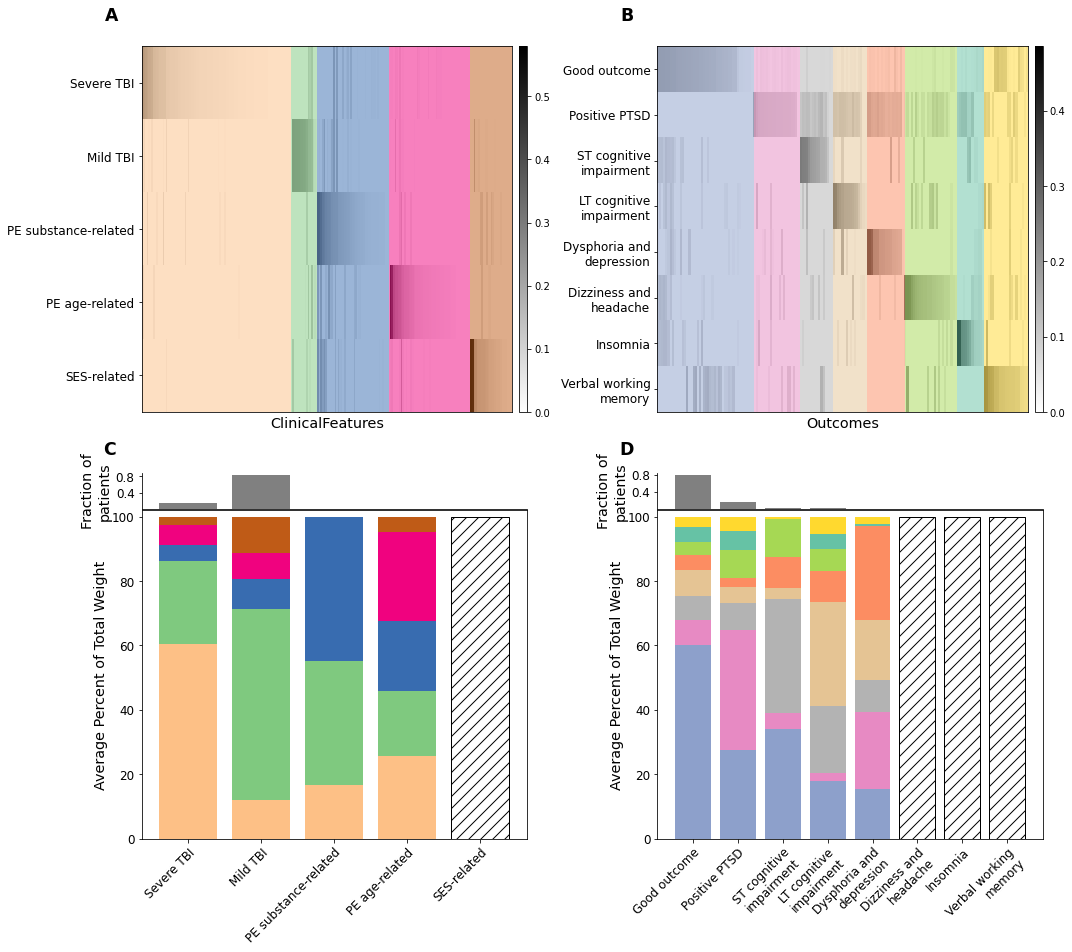

In [13]:
def add_label(ax, label, x=-0.1, y=1.07):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size='xx-large')    
#################################################

fig_width = 15
fig_height = 13.33

fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height))

axA = axes[0, 0]
axC = axes[1 ,0]
axB = axes[0, 1]
axD = axes[1, 1]


# below height and pad are in inches
axC_bar = make_axes_locatable(axC).append_axes("top", 0.5, pad=0.02, sharex=axC)
axD_bar = make_axes_locatable(axD).append_axes("top", 0.5, pad=0.02, sharex=axD)


fs = 'x-large'
ls = 'large'

nmfplot(bm_weights, bm_bases, axes=[axA, axC_bar, axC], bases_order=False, bases_labels=bm_bases_labels, 
        fontsize=fs, heatmap_xlabel='ClinicalFeatures', palette=bm_colors, labelsize=ls)



nmfplot(oc_weights, oc_bases, axes=[axB, axD_bar, axD], bases_order=False, bases_labels=oc_bases_labels, 
        fontsize=fs, heatmap_xlabel='Outcomes', palette=oc_colors, labelsize=ls)


for ax, lbl in zip([axA, axB] , "AB"):
    add_label(ax, lbl)

for ax, lbl in zip([axC_bar, axD_bar], "CD"):
    add_label(ax, lbl, y=1.5)

plt.tight_layout()
fig_path = '../../paper/MultiPanel_latent_features_NMF.png'
fig_dpi = 200
plt.tight_layout()
plt.savefig(fig_path, dpi=fig_dpi)

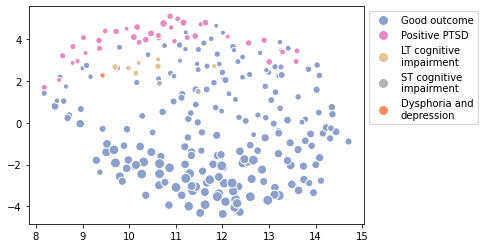

In [14]:
plot_umap_nmf_max(oc_emb, oc_weights, oc_bases_labels, right=True, palette=oc_colors)

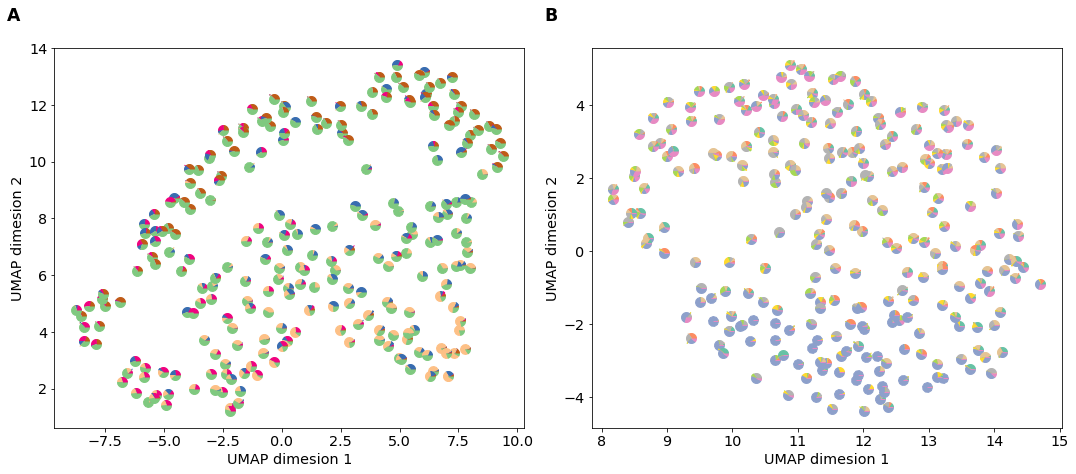

In [15]:
fig_width = 15
fig_height = 6.67

fig, axes = plt.subplots(1, 2, figsize=(fig_width, fig_height))
axE = axes[0]
axF = axes[1]

plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), bm_emb, s=70, ax=axE, fontsize=fs, palette=bm_colors)
plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), oc_emb, s=70, ax=axF, fontsize=fs, palette=oc_colors)

for ax, lbl in zip([axE, axF] , "AB"):
    add_label(ax, lbl)
    
plt.tight_layout()
fig_path = '../../paper/MultiPanel_latent_features_UMAP.png'
fig_dpi = 200
plt.savefig(fig_path, dpi=fig_dpi)

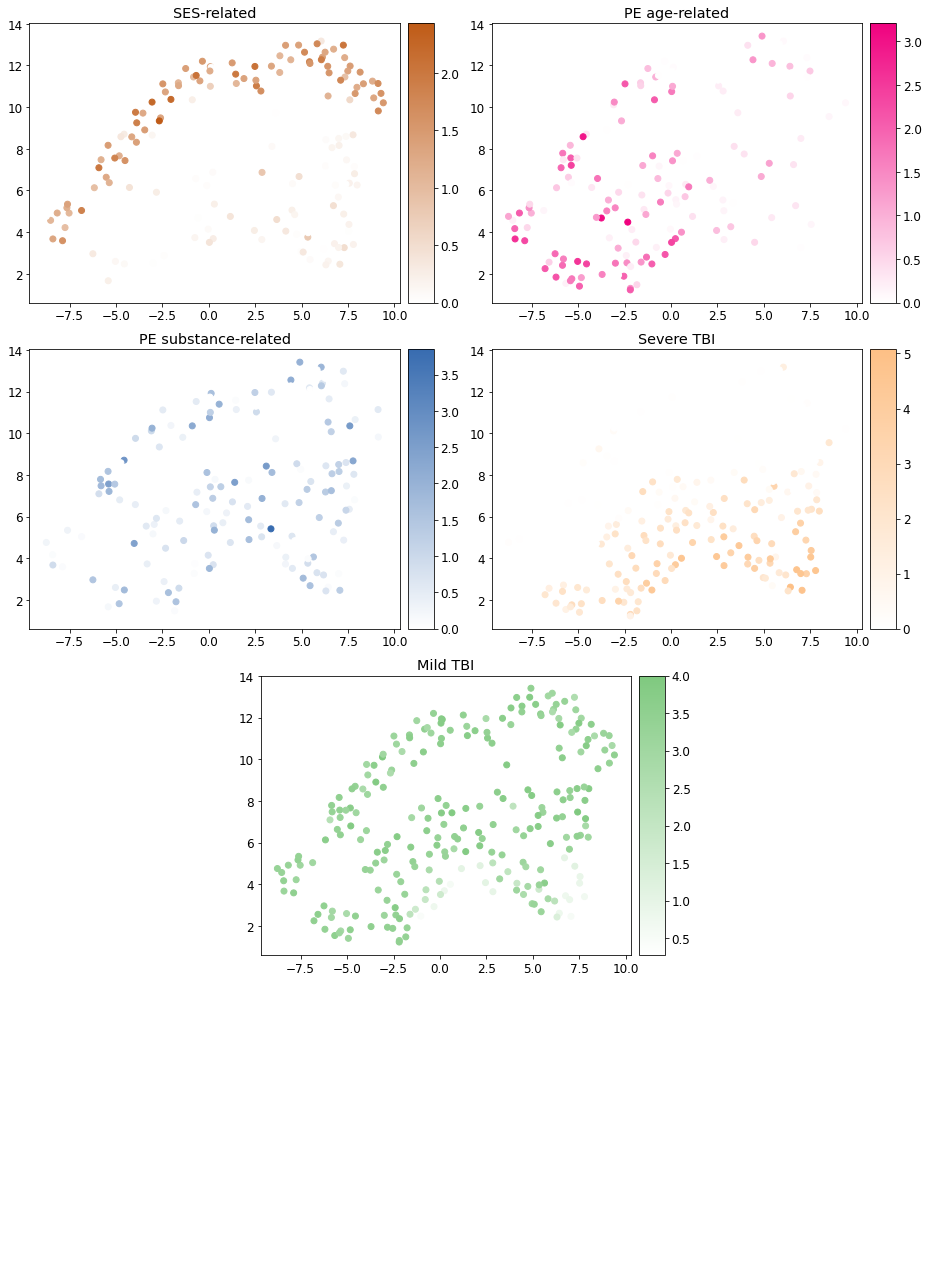

In [16]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(4):
    col = i%2
    axes.append(fig.add_subplot(gs[i//2, col*2:col*2+2]))
axes.append(fig.add_subplot(gs[2, 1:3]))
fig.add_subplot(gs[3, :]).axis('off')
cmaps = [mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), c]) for c in bm_colors]
plot_umap_nmf_weight(bm_emb, bm_weights, axes, bm_bases_labels, cmaps=cmaps)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/biomarker_weights_umap.png', dpi=200)

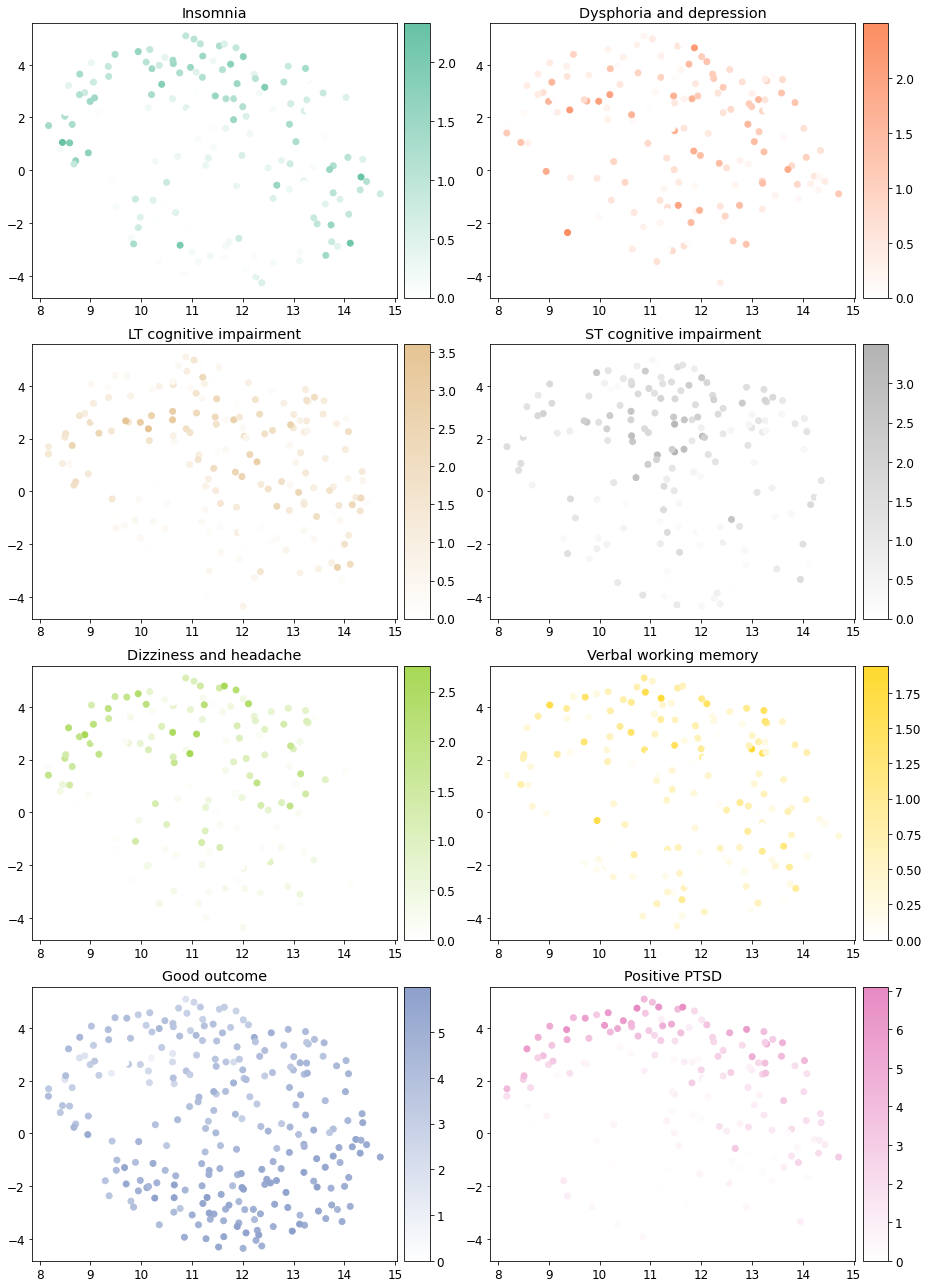

In [17]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(8):
    col = i % 2
    row = i // 2
    axes.append(fig.add_subplot(gs[row, col*2:col*2+2]))

cmaps = colormaps = [mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), c]) for c in oc_colors]
plot_umap_nmf_weight(oc_emb, oc_weights, axes, [s.replace('\n', ' ') for s in oc_bases_labels], cmaps=cmaps)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/outcome_weights_umap.png', dpi=200)

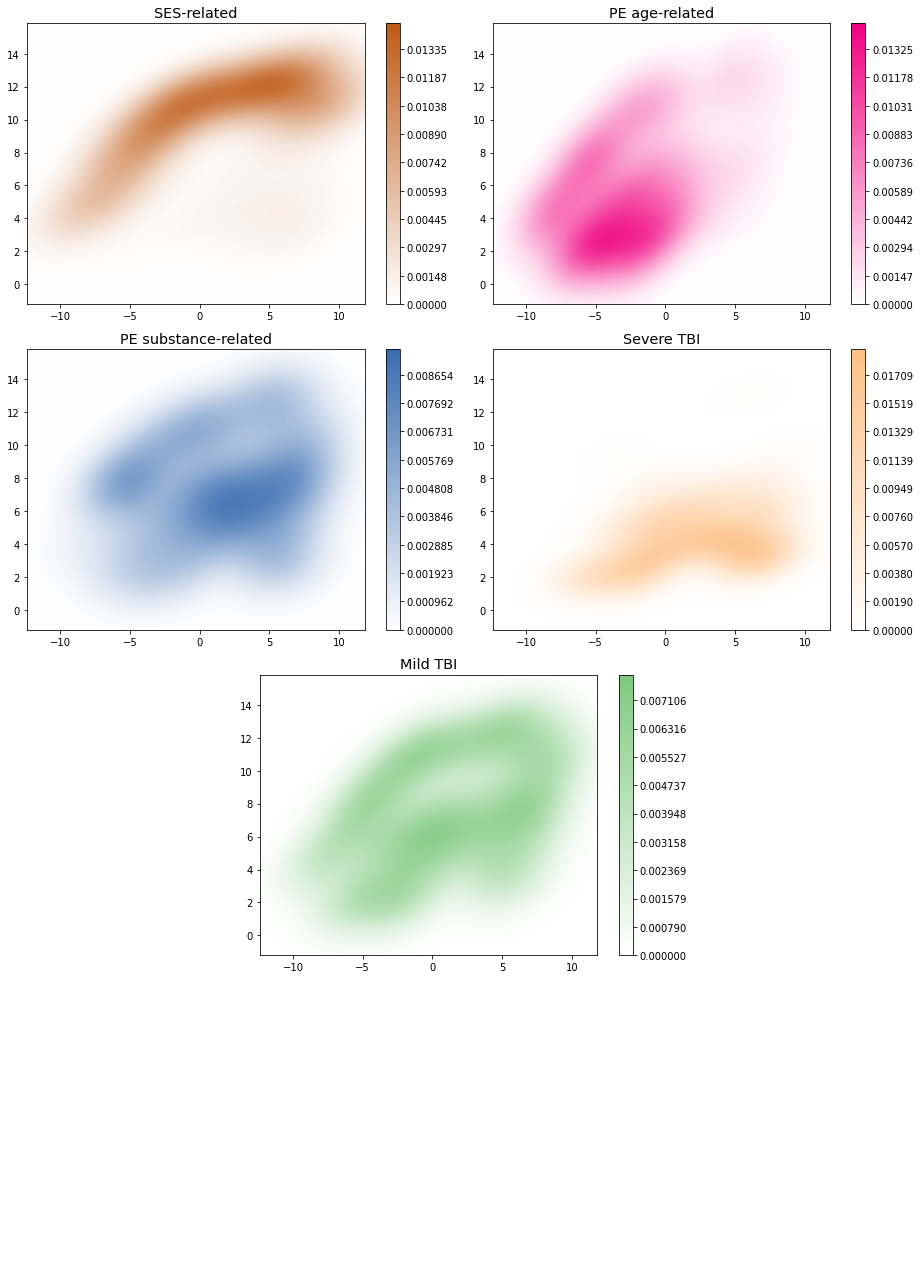

In [18]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(4):
    col = i%2
    axes.append(fig.add_subplot(gs[i//2, col*2:col*2+2]))
axes.append(fig.add_subplot(gs[2, 1:3]))
fig.add_subplot(gs[3, :]).axis('off')

plot_umap_nmf_weight_kde(bm_emb, bm_weights, bm_bases_labels, bm_colors, ax=axes)
plt.tight_layout()
plt.savefig('../../paper/biomarker_weights_umap_kde.png', dpi=200)

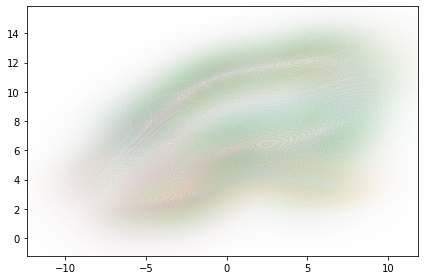

In [19]:
plot_umap_nmf_weight_kde(bm_emb, bm_weights, bm_bases_labels, bm_colors, alpha=0.2)
plt.tight_layout()
plt.savefig('../../paper/biomarker_weights_umap_kde_layered.png', dpi=200)

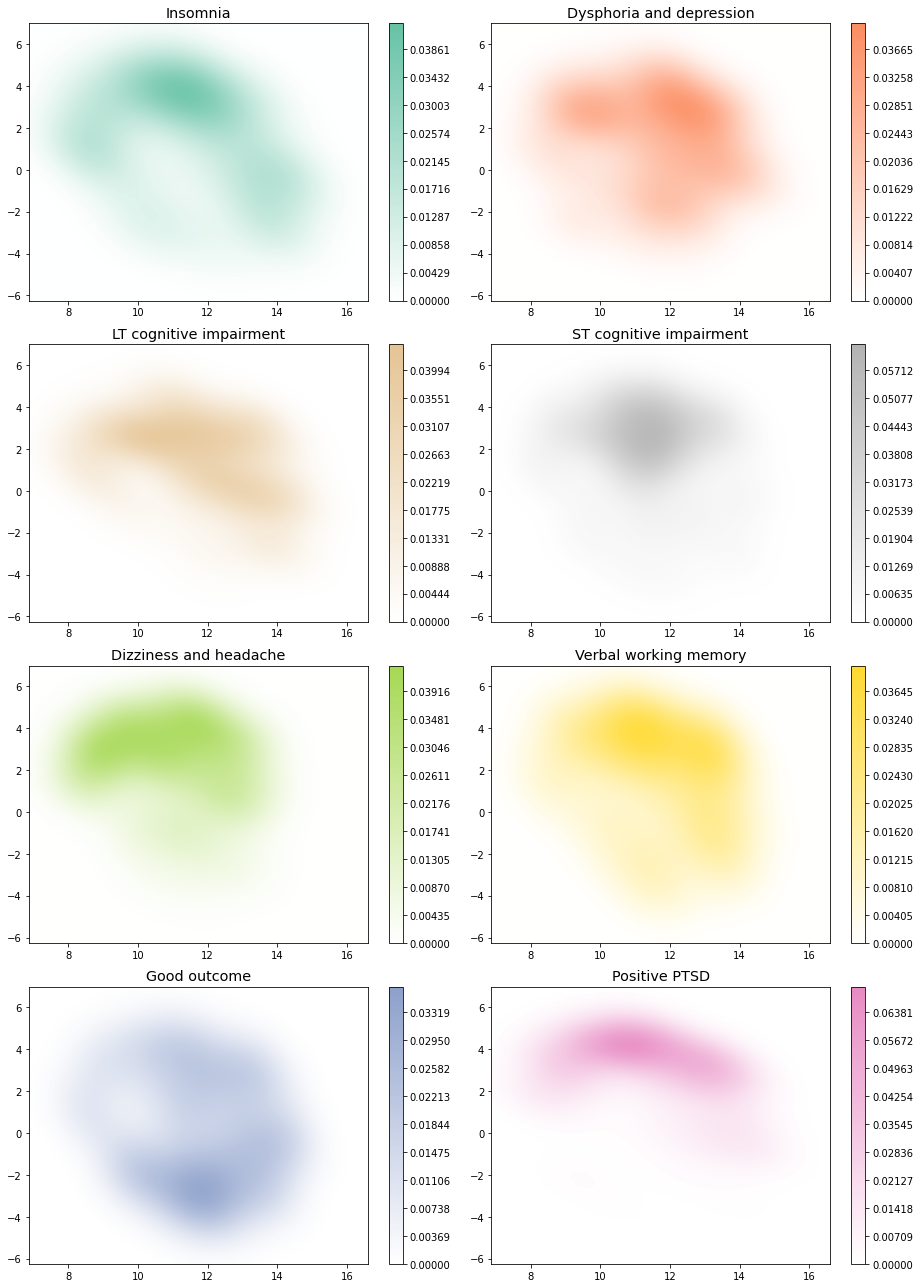

In [20]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(8):
    col = i % 2
    row = i // 2
    axes.append(fig.add_subplot(gs[row, col*2:col*2+2]))

plot_umap_nmf_weight_kde(oc_emb, oc_weights, [s.replace('\n', ' ') for s in oc_bases_labels], oc_colors, ax=axes)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/outcome_weights_umap_kde.png', dpi=200)

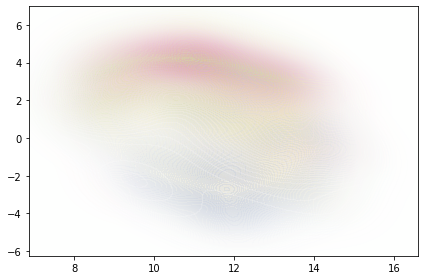

In [21]:
plot_umap_nmf_weight_kde(oc_emb, oc_weights, [s.replace('\n', ' ') for s in oc_bases_labels], oc_colors, alpha=0.2)
plt.tight_layout()
plt.savefig('../../paper/outcomes_weights_umap_kde_layered.png', dpi=200)

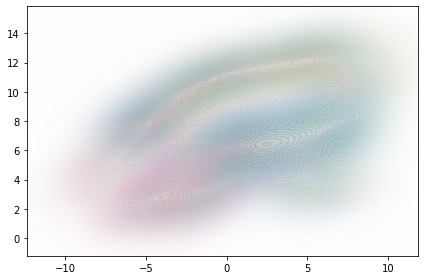

In [22]:
order = [3, 0, 1, 4, 2]
plot_umap_nmf_weight_kde(bm_emb, bm_weights[:, order], bm_bases_labels[order], bm_colors[order], alpha=0.2)
plt.tight_layout()
plt.savefig('../../paper/biomarker_weights_umap_kde_layered_random.png', dpi=200)

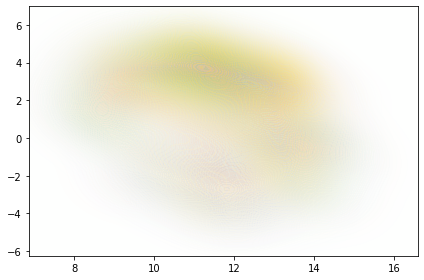

In [23]:
order = [4,3,7,2,6,1,0,5]
plot_umap_nmf_weight_kde(oc_emb, oc_weights[:, order], [s.replace('\n', ' ') for s in oc_bases_labels[order]], oc_colors[order], alpha=0.2)
plt.tight_layout()
plt.savefig('../../paper/outcomes_weights_umap_kde_layered_random.png', dpi=200)